# Graph Neural Network for Key Information Extraction
In this tutorial you will use:
- [**EasyOCR**](https://https://www.jaided.ai/easyocr/) to detect and recognize text within documents from [**FUNSD**](https://guillaumejaume.github.io/FUNSD/) dataset;
- [**PIL**](https://pillow.readthedocs.io/en/stable/) library to draw results on the document;
- [**Doc2Graph**](https://github.com/andreagemelli/doc2graph), a framweork able to preprocess documents, transform them to graphs and perform inference on them;
- [**DGL**](https://www.dgl.ai), a framework to train Graph Neural Networks.

## Dependencies
Follow the instructions in the README.md file!

## Preprocessing: from document to graph.

In this part you will:
- visualize a document using PIL
- exploit EasyOCR reader method to extract texts and positions within the given document
- use a KNN algorithm to find the connections within the detected objects
- use DGL primitive to create a graph

Let's download FUNSD first and then choose some documents to work with!

If correctly initialized, Doc2Graph has already downloade FUNSD for you in -> `DATA/FUNSD`

In [1]:
from pathlib import Path
from dotenv import dotenv_values
import os

# ROOT
HERE = Path('/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my/src')#(os.path.dirname(os.path.abspath(__file__)))
config = dotenv_values(HERE / "root.env")
ROOT = Path(config['ROOT'])
ROOT

PosixPath('/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my')

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.data.download import funsd

#! uncomment this to download.
# funsd() 

Let's visualize an example!

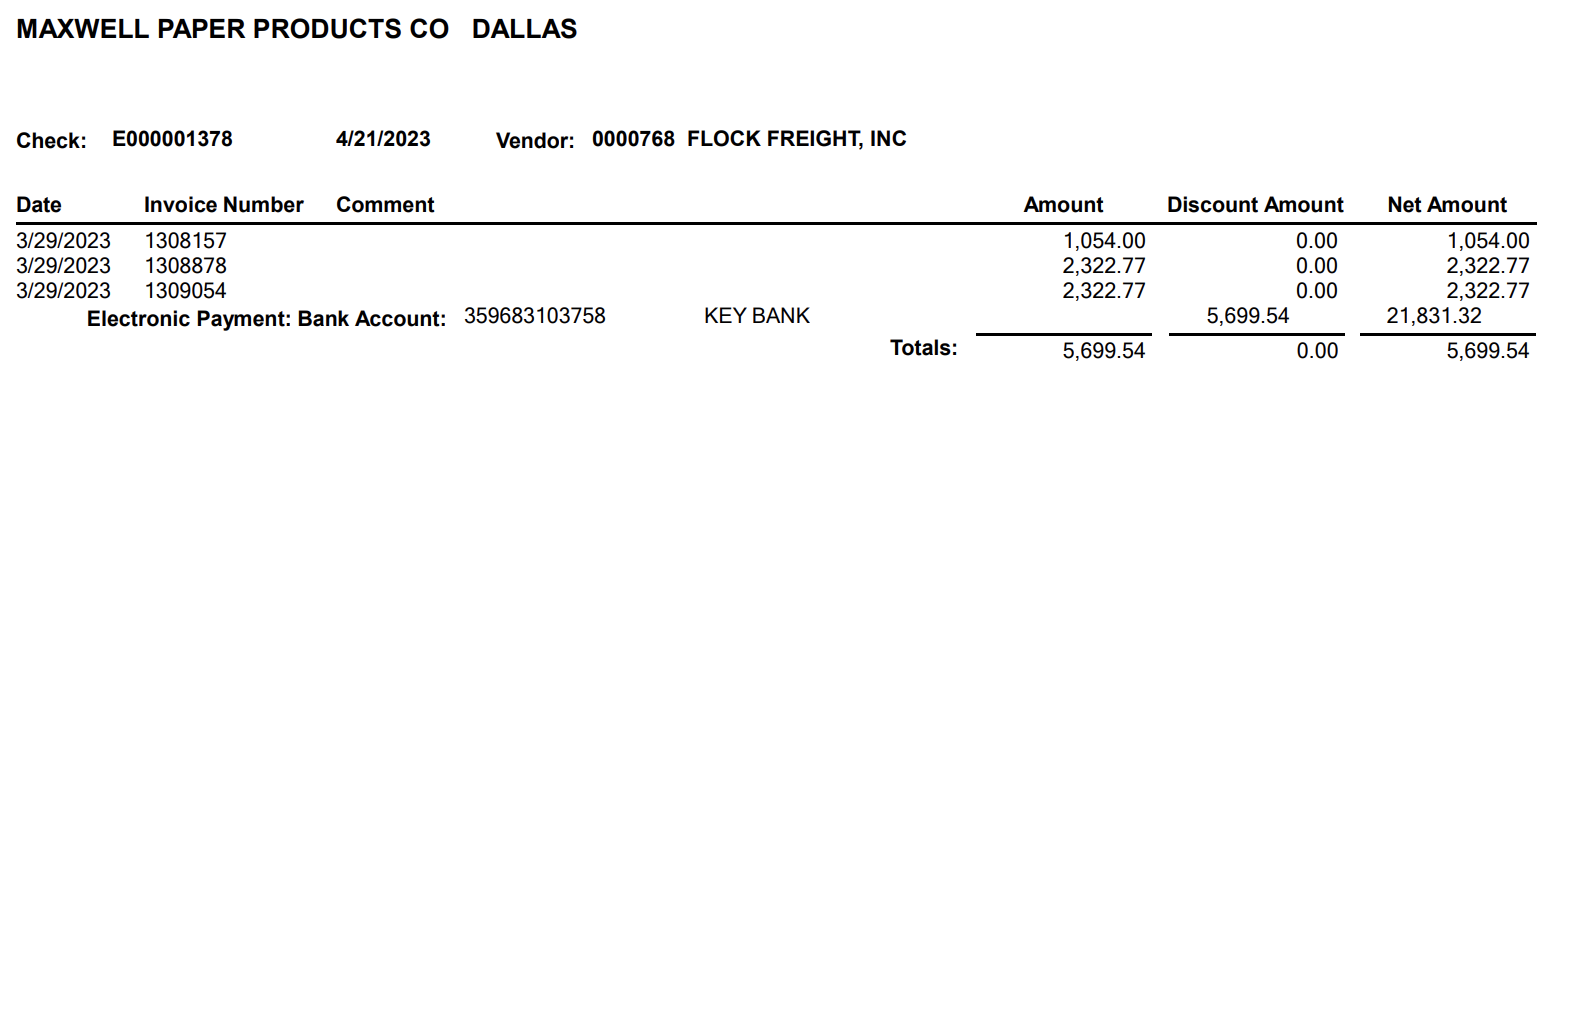

In [310]:
from src.paths import FUNSD_TEST, DATA ,CHECKPOINTS, REMITTANCE_VAL
from PIL import Image, ImageDraw, ImageFont


# funsd_test_images = FUNSD_TEST / 'images'
# image_name = '83996357.png' #! change this to see different outputs from FUNSD, or pass your own image!

funsd_test_images = DATA# / INF / 'images' 
image_name = 'i1.png'
image_path = str(DATA / image_name)
image = Image.open(image_path).convert('RGB')
#image.save(image_path)
image

In [280]:
import easyocr

from src.data.preprocessing import center

reader = easyocr.Reader(['en']) #! support multilingual!

def apply_ocr(path):
    result = reader.readtext(path, 
                             min_size=10, 
                            slope_ths=0.2, 
                            ycenter_ths=0.5, 
                            height_ths=0.5, 
                            width_ths=0.5,
                            decoder='wordbeamsearch', 
                            beamWidth=10, )
    boxs, texts = list(), list()

    # transform the OCR result in a handle format
    for r in result:
        box = [int(r[0][0][0]), int(r[0][0][1]), int(r[0][2][0]), int(r[0][2][1])]
        boxs.append(box)
        texts.append(r[1])
    
    return boxs, texts


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [202]:

def draw_results(img, boxs, links, labels):
    draw = ImageDraw.Draw(img)

    for box in boxs:
        draw.rectangle(box, outline='blue', width=3)
    
    if links:
        for idx in range(len(links['src'])):
            key_center = center(boxs[links['src'][idx]])
            value_center = center(boxs[links['dst'][idx]])
            draw.line((key_center, value_center), fill='violet', width=3)
            
def draw_boxes(image, boxes, labels=None, color='green', width=2):
    draw = ImageDraw.Draw(image, "RGBA")
    font = ImageFont.load_default()
    if labels:
        for box,label in zip(boxes,labels):
            if color=='green':
                fill=(0, 255, 0, 127)
            else:
                fill=(255, 0, 0, 127)
            draw.rectangle(box, outline=(color), width=width,fill=fill)
            text_position = (box[0]+10, box[1]-10)
            text = str(label)
            draw.text(text_position, text=text, font=font, fill=(255,0, 0)) # 
    else:
        for box in boxes:
            if color=='green':
                fill=(0, 255, 0, 127)
            else:
                fill=(255, 0, 0, 127)
            draw.rectangle(box, outline=(color), width=width,fill=fill)
        
    return image

In [300]:
#! get text boxes and contents
boxs, texts = apply_ocr(image_path)
res = draw_results(image.copy(), boxs,None, [])
image

Let's use now a KNN algorithm to connect the k neirest neighbors per each node:
- the discovered pairs will be connected visually
- the connections will become our **edges**

To do so, we can use the Doc2Graph defined method `knn_connection()` of `GraphBuilder()`.

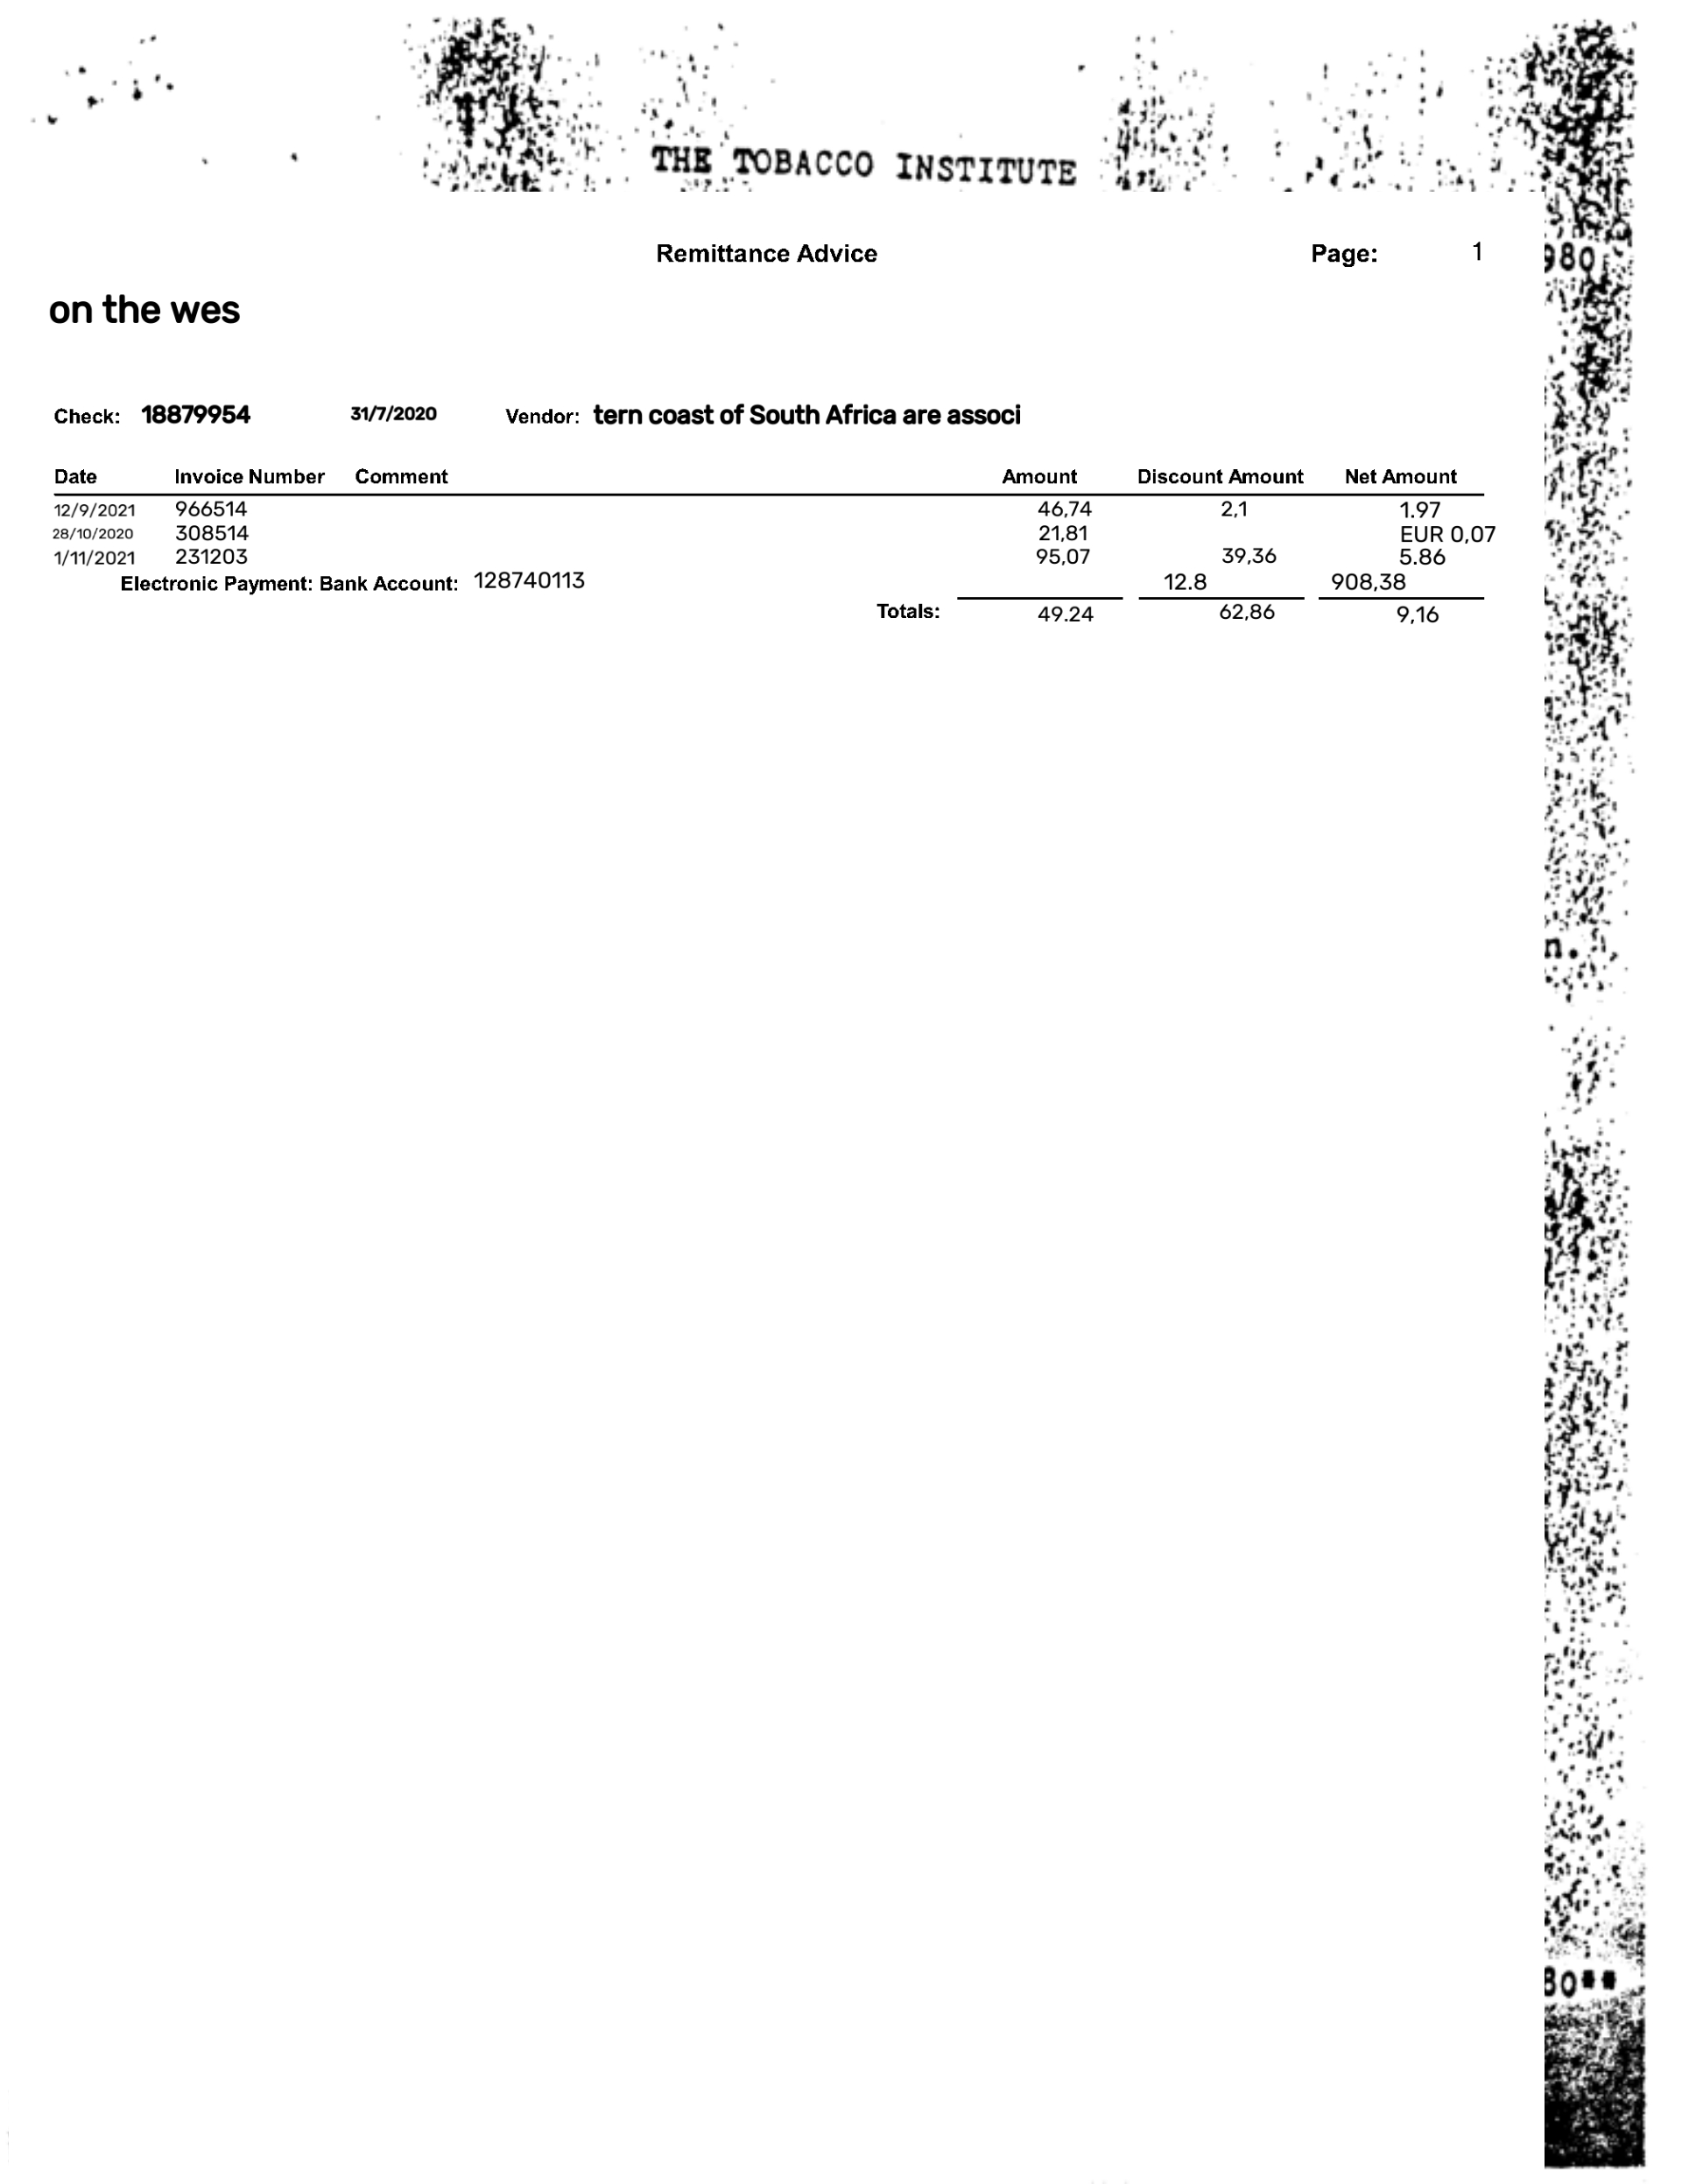

In [301]:
from src.data.graph_builder import GraphBuilder

k = 4 #! try changing this value!

gb = GraphBuilder()
u, v = gb.fully_connected(range(len(boxs)))
links = {'src': u, 'dst': v}
draw_results(image.copy(), boxs, links, None)
image

Now that we have obtained both **nodes** and **edges**, it is time to build a **graph** using DGL. From the their official documentation: 

> *DGL represents a directed graph as a DGLGraph object. You can construct a graph by specifying the number of nodes in the graph as well as the list of source and destination nodes.* 

We are gonna use the second case, in our code `(u, v)`: output of `knn_connection()` and obtained from the positions of `boxs`.

You can obtain the **same result** using the `GraphBuilder()` method `get_graph()` with the following parameters:
- `src_path`: a list of paths to your images
- `src_data = 'CUSTOM'`: to call the scripts to build a graph on your data (and not on the datasets used for training the model)

You will see an higher number of "num_edges" compared to the previous result because internally doc2graph uses a "fully connected" approach instead of a knn one.

In [311]:
graphs, node_labels, edge_labels, features = gb.get_graph([image_path], 'CUSTOM')
graph = graphs[0] # we have only one for this tutorial!
graph

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Graph(num_nodes=38, num_edges=1406,
      ndata_schemes={}
      edata_schemes={})

In [285]:
features.keys()

dict_keys(['paths', 'texts', 'boxs'])

## Inference: let's use AI to spot key-value pairs

In this part you will:
- prepare the graph defined beforehand for inference, evaluating node features
- use Doc2Graph model to predict node and edge classes for key-value spotting
- visualize and save results

Doc2Graph is a **multimodal** network, meaning that relies on different features:
- geometric features, encoding the positions of nodes
- textual features, encoding texts using pretrained language model given by SpaCy
- visual features, encoding style, font, etc. using a convolutional network

<img src="../model.png" width=60%>

The class `FeatureBuilder()` does this for us, using the `add_features()` method.

You will see now `ndata_schemes` and `edata_schemes` populated with new information regarding the dimension of embedding tensors. The graph is not empty anymore!

In [286]:
from src.data.feature_builder import FeatureBuilder

device = 'cpu'#'cuda:0' # change this to 'cpu' in case you cannot use hardware acceleration
fb = FeatureBuilder(d=device)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_lg' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [312]:
chunks, _ = fb.add_features(graphs, features) # chunks is used by the model to merge different embeddings together!
graphs, chunks

adding features: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


([Graph(num_nodes=38, num_edges=1406,
        ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(1752,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32)})],
 [4, 300, 1448])

Now let's use the `SetModel()` class to create a model object that will be used to perform inference on the given graph!

For this tutorial, the model it has been already pretrained: you can train your own following the `README.md` file of this repo!

In [288]:
import torch
from src.models.graphs import SetModel
from src.paths import CHECKPOINTS

device = 'cpu'
sm = SetModel(name='e2e', device=device)
model = sm.get_model(7, 1, [4, 300,1448], False) # 4 and 2 refers to nodes and edge classes, check paper for details!
model.load_state_dict(torch.load(CHECKPOINTS / 'e2e-20230718-1344.pt', map_location=torch.device('cpu'))) # load pretrained model
model.eval() # set the model for inference only


### MODEL ###
-> Using E2E
-> Total params: 20572
-> Device: False



E2E(
  (projector): InputProjector(
    (modalities): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=10, bias=True)
        (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=300, out_features=10, bias=True)
        (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=1448, out_features=10, bias=True)
        (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (message_passing): GcnSAGELayer(
    (linear): Linear(in_features=60, out_features=30, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (lynorm): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
  )
  (edge_pred): MLPPredictor_E2E(
 

Now let's pass the graph to the model to spot the key-value pairs within the graph (a.k.a. the document).
The model accept two argument:
- the graph itself, to perform the message passing;
- the node features to encode and then classify nodes and edges.

In [144]:
from src.data.dataloader import Document2Graph
from src.paths import TEST_SAMPLES, INF, REMITTANCE_TEST

test_data = Document2Graph(name='REMITTANCE TEST', src_path=INF, device = device, output_dir=TEST_SAMPLES)
test_data.get_info()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_lg' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
adding features: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]



REMITTANCE TEST dataset:
-> graphs: 2
-> node labels: ['O' 'invoice_amount' 'invoice_date' 'invoice_number' 'payment_amount'
 'payment_date' 'payment_number']
-> edge labels: ['none']
-> node features: 1752
-> edge type: fully
-> textual feats: True
-> visual feats: True
-> edge feats: True
-> graph example: Graph(num_nodes=33, num_edges=1056,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(1752,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [165]:
test_data.paths

['/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my/DATA/INF/images/f03476f0-6b5e-4604-ae46-d090b89f5107.jpg',
 '/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my/DATA/INF/images/ff9449e4-64ed-4fde-9e96-026fb1a5f284.jpg']

In [182]:
len(test_data)

2

In [289]:
test_graph.ndata['feat'].shape

torch.Size([64, 1752])

In [57]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

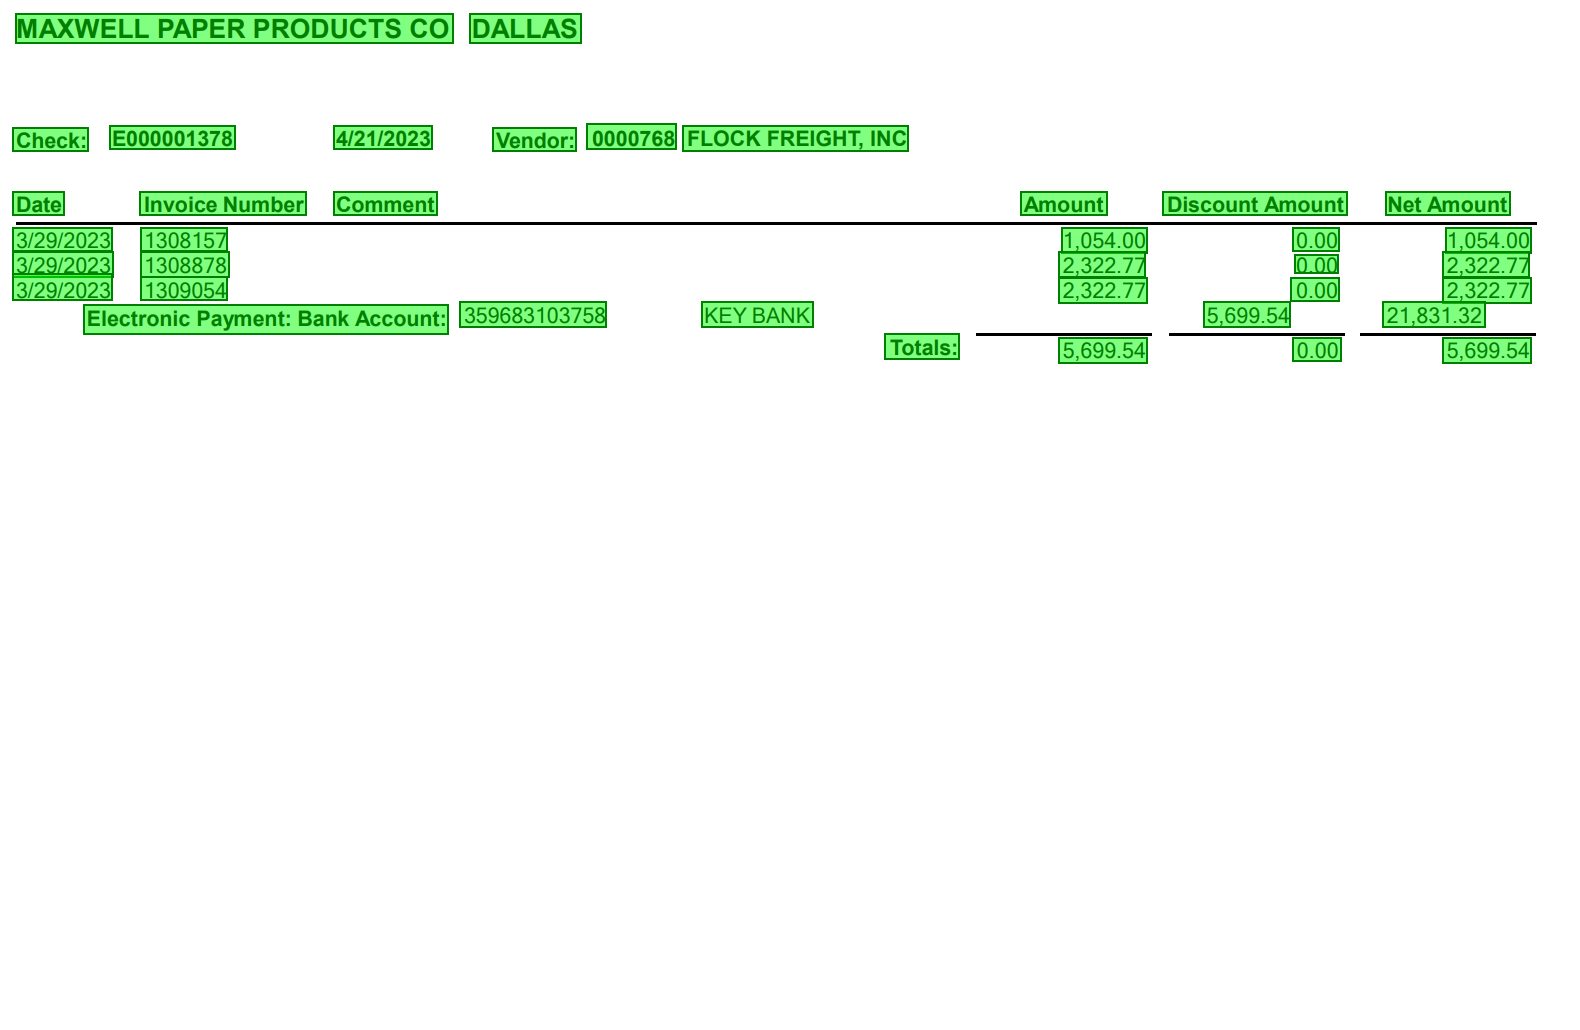

In [320]:
inf_graph = graphs[0]
boxes = list(inf_graph.ndata['geom'].numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]
draw_boxes(image.copy(), boxes, None)

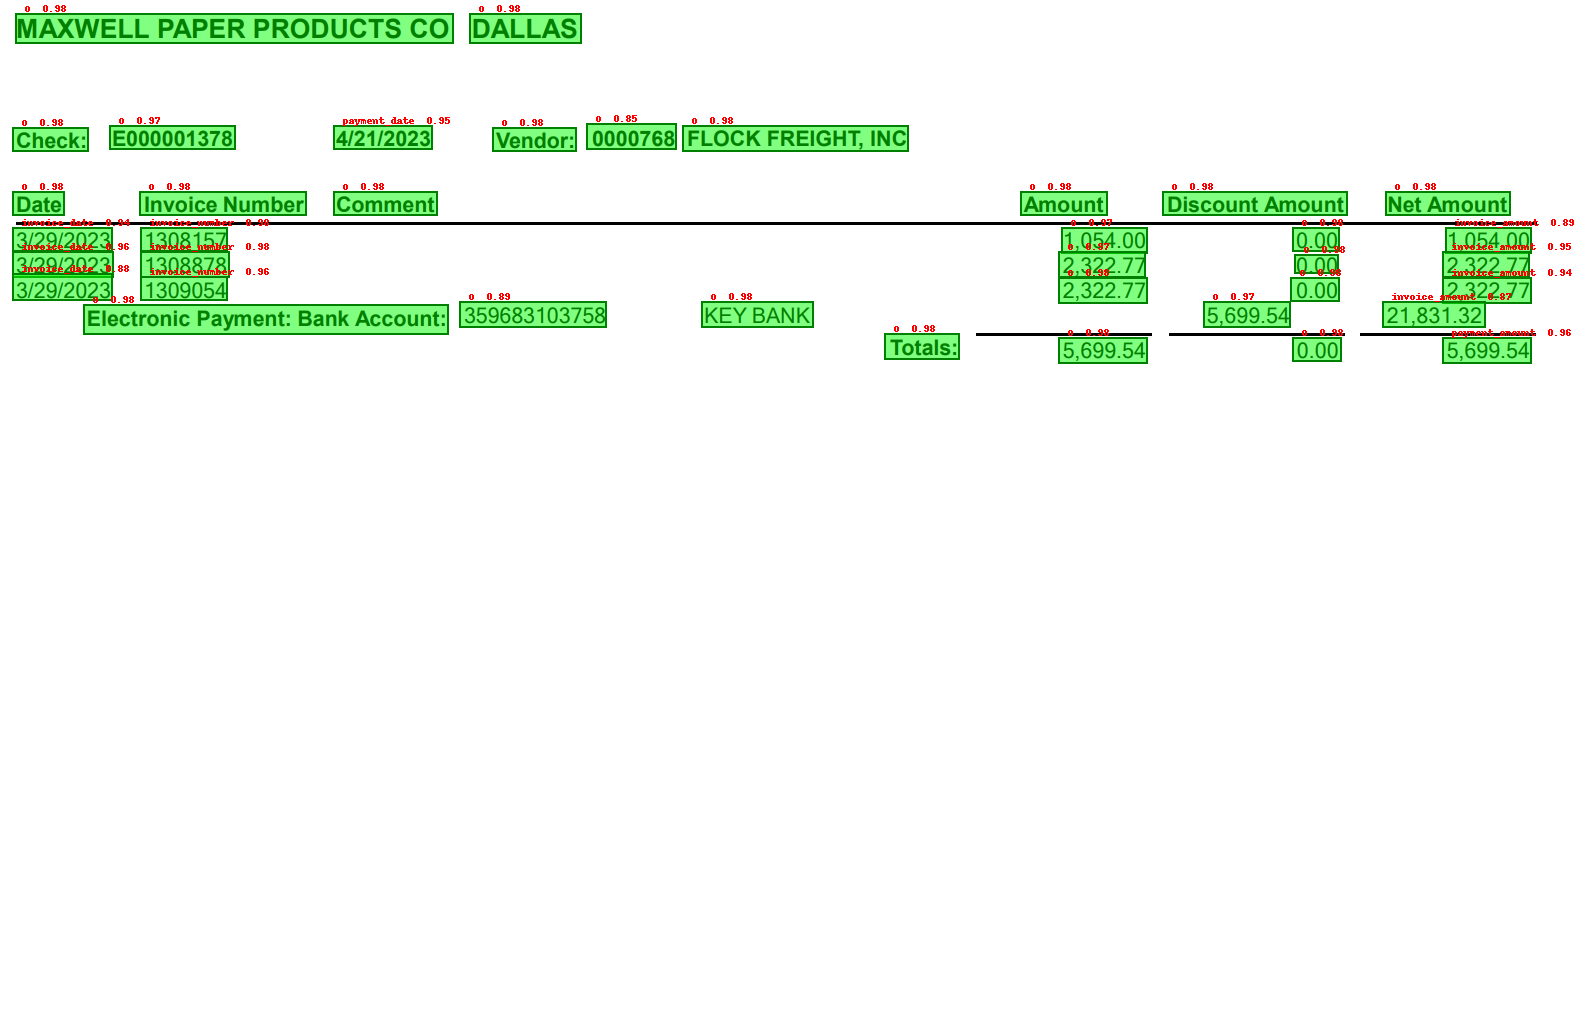

In [326]:
from torch.nn import functional as F
import numpy as np
from src.training.utils import *

ind=1
#graph = test_data.graphs[ind]
#inference = Image.open(test_data.paths[ind]).convert('RGB')
graph = graphs[0]
inference = image.copy()
size = inference.size
with torch.no_grad():
    n, e = model(graph.to(device), graph.ndata['feat'].to(device))
    _, epreds = torch.max(F.softmax(e, dim=1), dim=1)
    score, npreds = torch.max(F.softmax(n, dim=1), dim=1)
    
    arr = npreds.numpy()
    li = list(np.where(arr>=0)[0]) 
    
    score = [f'%6.2f' % score[i] for i in li]
    labels = [test_data.node_unique_labels[arr[i]]+score[i] for i in li]

    # save results
    links = (epreds == 1).nonzero(as_tuple=True)[0].tolist()
    u, v = graph.edges()
    boxes = list(graph.ndata['geom'].numpy())
    #boxes = [sg(box, size) for box in boxes]
    boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]
    entities =  [boxes[i] for i in li]
    #contents = features['texts'][0]

    inference = draw_boxes(inference, entities, labels)
    #draw = ImageDraw.Draw(inference)

    # for i, idx in enumerate(links):
    #     key_center = center(entities[u[idx]])
    #     value_center = center(entities[v[idx]])
    #     draw.line((key_center, value_center), fill='violet', width=3)
    #     draw.ellipse([(key_center[0]-4,key_center[1]-4), (key_center[0]+4,key_center[1]+4)], fill = 'green', outline='black')
    #     draw.ellipse([(value_center[0]-4,value_center[1]-4), (value_center[0]+4,value_center[1]+4)], fill = 'red', outline='black')
    
inference